In [16]:
import numpy as np
from astropy.io import fits
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

def photonCounting(average,
                EMGain=1.0,
                RN=0.0,
                PCbias=0.0,
                threshold=6,
                poisson=True,
                EMStats=True,
                PCmode=True):


        # calculate electron generation in the CCD frame
        if poisson:
            atEMRegister = np.random.poisson(average)
        else:
            atEMRegister = average
        
    
        # calculate the number of electrons after the EM register
        if EMStats:
            EMmask = atEMRegister>0
            afterEMRegister = np.zeros(atEMRegister.shape)
            afterEMRegister[EMmask] = np.random.gamma(atEMRegister[EMmask],EMGain,atEMRegister[EMmask].shape)
        else:
            afterEMRegister = EMGain*atEMRegister
        
        # add read noise
        if EMStats and RN>0:
            afterRN = afterEMRegister+np.random.normal(PCbias,RN,afterEMRegister.shape)
            # clip at zero
            afterRN[afterRN<0]=0
        else:
            afterRN = afterEMRegister+PCbias

        # add photon counting thresholding
        if PCmode:
            PCmask = afterRN>PCbias+threshold*RN
            afterRN[PCmask]=1.0 #(afterRN[PCmask]-par.PCbias)/par.EMGain
            afterRN[~PCmask]=0.
        else:
            afterRN -= PCbias
            afterRN /= EMGain
    
        return afterRN


def readoutPhotonFluxMapWFIRST(
                fluxMap, 
                tottime,
                inttime=None,
                QE=1.0,
                darkBOL=1.4e-4, 
                darkEOL=2.8e-4, 
                CIC=1e-2,
                eff=1.0,
                EMGain=2500.,
                RN=100.0,
                PCbias=1000.0,
                threshold=6.,
                lifefraction=0.0,
                dqeKnee=0.858,
                dqeFluxSlope=3.24,
                dqeKneeFlux=0.089,
                nonoise=False,
                poisson=True,
                EMStats=True,
                PCmode=True):
    # if inttime is None, determine the exposure time so that the brightest pixel is only 0.1 electrons  
    if inttime is None:
        exptime = 0.1/np.amax(QE*eff*fluxMap)
        print("Individual exposure time: %.2f" % exptime)
    else:
        exptime=inttime
    
    photoelectrons = QE*eff*fluxMap*exptime
    
    if nonoise:
        return photoelectrons
    else:
    
        
        if lifefraction>0.0:
            photoelectrons= QE*np.maximum(np.zeros(photoelectrons.shape),np.minimum(np.ones(photoelectrons.shape)+lifefraction*(dqeKnee-1.),np.ones(photoelectrons.shape)+lifefraction*(dqeKnee-1)+lifefraction*dqeFluxSlope*(photoelectrons/QE-dqeKneeFlux)))

        dark = darkBOL+lifefraction*(darkEOL-darkBOL)
        average = photoelectrons+dark*exptime+CIC
    
        frame = np.zeros(average.shape)
        
        nreads = int(tottime/exptime)
        for n in range(nreads):
            newread = photonCounting(average,
                                    EMGain=EMGain,
                                    RN=RN,
                                    PCbias=PCbias,
                                    threshold=threshold,
                                    poisson=poisson,
                                    EMStats=EMStats,
                                    PCmode=PCmode)
            frame += newread
        frame/=nreads
        if PCmode:
            frame*=np.exp(RN*threshold/EMGain)
            frame=-np.log(1.-frame)
        frame/=exptime
        return frame

Populating the interactive namespace from numpy and matplotlib


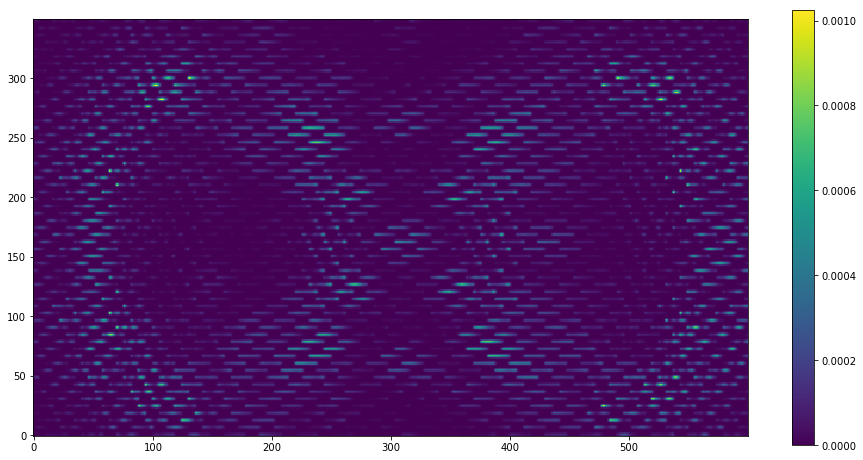

In [2]:
testMap_filepath = '/Users/mrizzo/IFS/OS5_SIM_2.0_noiseless/average/average_target_star_detector.fits'
testMap = fits.getdata(testMap_filepath)[350:700,200:800]
plt.figure(figsize=(16,8))
plt.imshow(testMap)
plt.colorbar()

In [17]:
res = readoutPhotonFluxMapWFIRST(
                testMap, 
                tottime=100000,
                inttime=100)

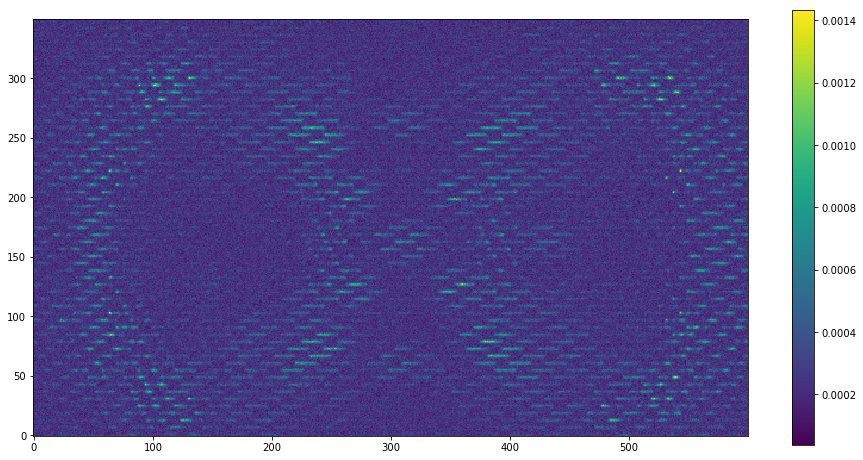

In [18]:
plt.figure(figsize=(16,8))
plt.imshow(res)
plt.colorbar()